In [1]:
import argparse
import json
import numpy as np
import PIL
import tensorflow

In [5]:
!pip -q install --upgrade git+https://github.com/tensorflow/lucid@master

In [7]:
from lucid.scratch.atlas_pipeline import pipeline


## Inputs
The pipeline expects two main inputs, the layout (x,y coordinates that result from UMAP or t-SNE) and metadata that you can use to render a custom atlas. First we download some example data:

In [10]:
tensorflow.gfile.MakeDirs("data")

In [27]:
%%bash
wget -nv https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-umap-x.npy
mv face-released-umap-x.npy data/
wget -nv https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-umap-y.npy
mv face-released-umap-y.npy data/
wget -nv https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-ids.npy
mv face-released-ids.npy data/
wget -nv https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-drawings.npy
mv face-released-drawings.npy data/
wget -nv https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-countrycodes.npy
mv face-released-countrycodes.npy data/

2019-04-11 14:09:21 URL:https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-umap-x.npy [646792/646792] -> "face-released-umap-x.npy" [1]
2019-04-11 14:09:21 URL:https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-umap-y.npy [646792/646792] -> "face-released-umap-y.npy" [1]
2019-04-11 14:09:23 URL:https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-ids.npy [10346752/10346752] -> "face-released-ids.npy" [1]
2019-04-11 14:09:40 URL:https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-drawings.npy [64634875/64634875] -> "face-released-drawings.npy" [1]
2019-04-11 14:09:40 URL:https://storage.googleapis.com/atlas-pipeline/quickdraw/face-released-countrycodes.npy [1293456/1293456] -> "face-released-countrycodes.npy" [1]


In [14]:
# the layout has an x and y coordinate numpy array for each datapoint
x = np.load("data/face-released-umap-x.npy")
y = np.load("data/face-released-umap-y.npy")
print("x,y", len(x), len(y))
layout = {
    "x": x,
    "y": y
}

x,y 161666 161666


In [28]:
ids = np.load("data/face-released-ids.npy")
countrycodes = np.load("data/face-released-countrycodes.npy")
drawings = np.load("data/face-released-drawings.npy")

In [29]:
metadata = {
    "ids": ids,
    "countrycodes": countrycodes,
    "drawings": drawings
}

## Tiles
The cornerstone of the pipeline is the generation of tiles, which are blocks of grid cells that allow us to aggregate and render points. The tiles are just collections of indices into the input arrays.  


We have a few key parameters for generating tiles, namely the number of cells we want total, the number of cells to a tile and the size in pixels of a cell.

In [18]:
params = {
    "name": "faces", # a prefix for our tile files
    "directory": "data/quickdraw", # the directory in the data folder where we will save the rendered tiles and aggregated data
    "n_cells": [16, 32, 64], # number of cells in each layer
    "n_tile": 16, # number of cells in a tile
    "cell_size": 100,# size in pixels for each cell
    "scale_density": True,
    "scale_type": PIL.Image.LANCZOS
}

## Render
The ability to define a custom rendering function for a grid cell provides a great deal of flexibility over how your data is displayed.

In [20]:
import numpy as np
from PIL import Image

# utility function that samples a raster line from two end points
# from https://stackoverflow.com/questions/44159861/how-do-i-parse-this-ndjson-file-in-python
def get_line(x1, y1, x2, y2):
  points = []
  issteep = abs(y2-y1) > abs(x2-x1)
  if issteep:
    x1, y1 = y1, x1
    x2, y2 = y2, x2
  rev = False
  if x1 > x2:
    x1, x2 = x2, x1
    y1, y2 = y2, y1
    rev = True
  deltax = x2 - x1
  deltay = abs(y2-y1)
  error = int(deltax / 2)
  y = y1
  ystep = None
  if y1 < y2:
    ystep = 1
  else:
    ystep = -1
  for x in range(x1, x2 + 1):
    if issteep:
      points.append((y, x))
    else:
      points.append((x, y))
    error -= deltay
    if error < 0:
      y += ystep
      error += deltax
  # Reverse the list if the coordinates were reversed
  if rev:
    points.reverse()
  return points   

# create a pixelized image from a sketch
def create_image(sketch, size):
  div = 64/size * 4 * 1.2
  pixels = np.zeros((size, size))
  x = -1
  y = -1
  for stroke in sketch:
    for i in range(len(stroke[0])):
      if x != -1: 
        for point in get_line(stroke[0][i], stroke[1][i], x, y):
          pixels[int(point[0]/div),int(point[1]/div)] = 1
      pixels[int(stroke[0][i]/div),int(stroke[1][i]/div)] = 1
      x = stroke[0][i]
      y = stroke[1][i]
    x = -1
    y = -1
  #resized_pixels = resize(pixels.T, (64, 64)).astype(np.float)/255.0
  return pixels.T


def render(cell, params, metadata, layout, summary):
  # render first drawing from the cell
  i = cell["gi"][0]
  # cc = metadata["countrycodes"][i]

  drawing = metadata["drawings"][i]
  p = create_image(drawing, params["cell_size"])

  arr = np.uint8(255 - p*255)
  return Image.fromarray(arr).convert(mode="RGB")

## Aggregate
We also allow you to define a custom aggregation function that can return a json object for each cell. This can be utilized in the frontend for visualization.

In [21]:
def aggregate(cell, params, metadata, layout, summary):
  i = cell["gi"][0]
  return { 
    "count": len(cell["gi"]),
    "sample": metadata["drawings"][i]
  }

## Generate tiles
The framework will handle this code, automatically parallelizing the rendering for you.

In [30]:
pipeline.run(render, aggregate, params, metadata, layout)

num tiles 1
summary {'x_min': -3.1541922, 'x_max': 4.9472136, 'y_min': -4.006604, 'y_max': 4.1479793, 'x_bin': 0.5063378810882568, 'y_bin': 0.5096614360809326, 'max_density': 2486, 'min_density': 1, 'num_cells': 171, 'total_count': 161666}
aggregate tile 1 / 1
saving data/quickdraw/faces-tile_16_16_0_0.json
render tile 1 / 1
cell 171 / 171

saving data/quickdraw/faces-tile_16_16_0_0.png
num tiles 2
summary {'x_min': -3.1541922, 'x_max': 4.9472136, 'y_min': -4.006604, 'y_max': 4.1479793, 'x_bin': 0.2531689405441284, 'y_bin': 0.2548307180404663, 'max_density': 645, 'min_density': 1, 'num_cells': 726, 'total_count': 161666}
aggregate tile 1 / 4
saving data/quickdraw/faces-tile_32_16_0_0.json
render tile 1 / 4
cell 193 / 193

saving data/quickdraw/faces-tile_32_16_0_0.png
aggregate tile 2 / 4
saving data/quickdraw/faces-tile_32_16_0_1.json
render tile 2 / 4
cell 184 / 184

saving data/quickdraw/faces-tile_32_16_0_1.png
aggregate tile 3 / 4
saving data/quickdraw/faces-tile_32_16_1_0.json
re

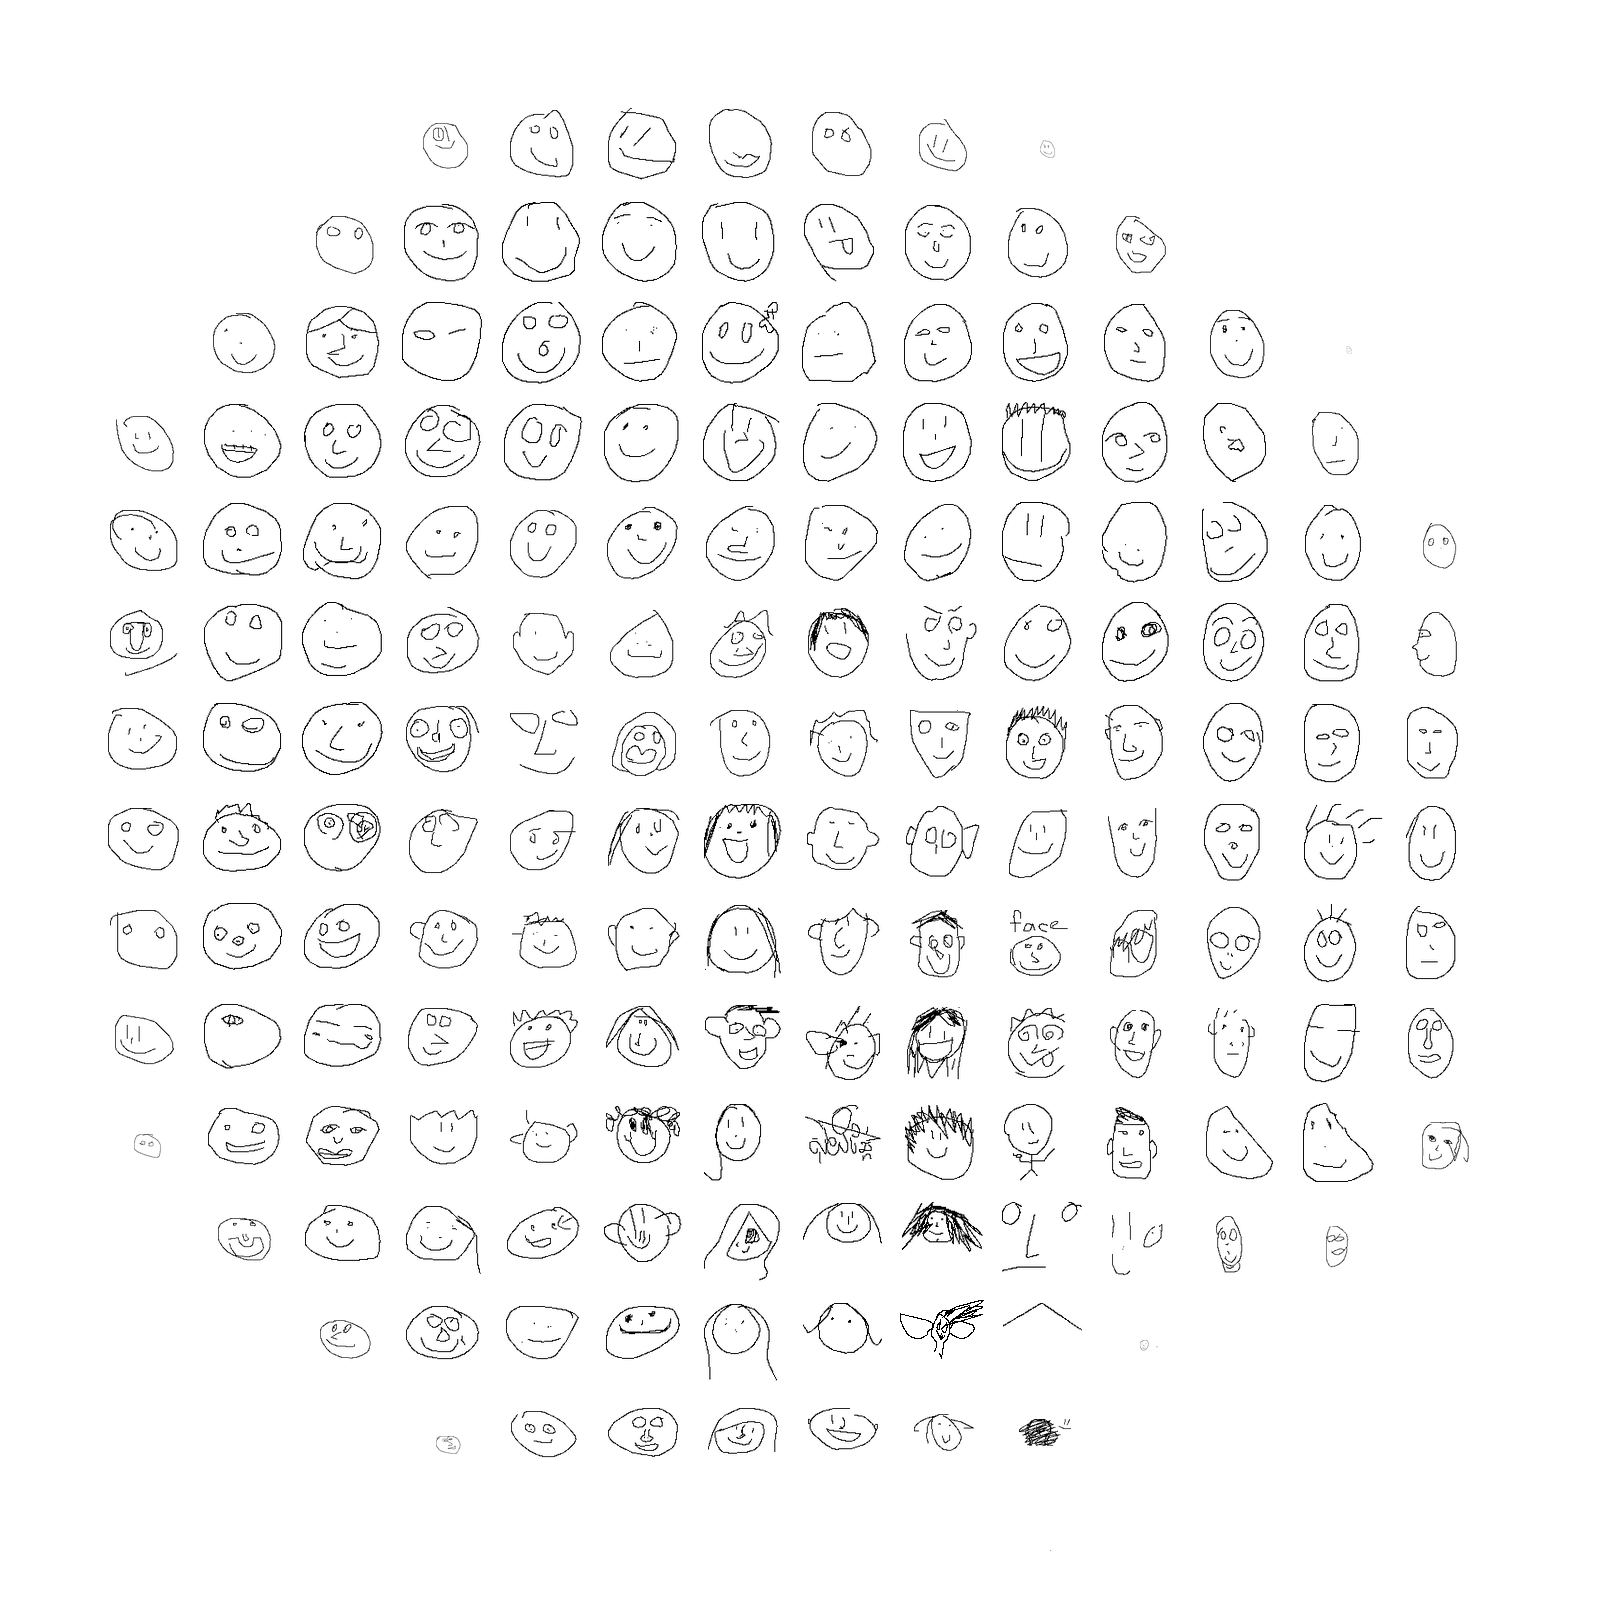

In [31]:
import IPython
IPython.display.Image(filename="data/quickdraw/faces-tile_16_16_0_0.png")